In [1]:
#two body problem example

using Pkg
Pkg.activate(".")
using LinearAlgebra
using ForwardDiff
using Plots 
using TSSOS 
using DynamicPolynomials
using DifferentialEquations  

  Activating project at `~/Research/polynomial_opt`


In [2]:
#gravitational parameter for the Earth 
μ = 3.986004418e5 #km3/s2

398600.4418

In [3]:
#iss initial conditions
r0 = [6791.0; 0; 0] #km
v0 = [0; cosd(51.5)*7.66; sind(51.5)*7.66] #km/s
x_initial = [r0; v0]

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [4]:
#one iss period is around 90-93 minutes
#revs = 5

#working for 1/4 rev...
#suboptimality gap of 21% 
revs = 0.25

#finding the period
r_initial = norm(r0)

#finding the period for 1 rev
iss_period = 2*pi*sqrt(r_initial^3/μ)

period = revs*iss_period 

1392.3601493207534

In [5]:
#amount of knot points per orbit 
knot_pts = 10

10

In [6]:
#total number of knot points
#N=knot_pts*revs

#when revs is less than 1
N = knot_pts

10

In [7]:
#define a timestep
h = period/(N-1) 

154.7066832578615

In [8]:
function two_body_dynamics(x)

    q = x[1:3]
    v = x[4:6]

    a = zeros(eltype(x), size(x))

    r = norm(q)
    
    a[1:3] = v

    a[4:6] = (-μ/r^3)*q

    return a

end

two_body_dynamics (generic function with 1 method)

In [9]:
function rk4_integrator(x)


    f1 = two_body_dynamics(x)
    f2 = two_body_dynamics(x+0.5*h*f1)
    f3 = two_body_dynamics(x+0.5*h*f2)
    f4 = two_body_dynamics(x+h*f3)

    xnext = x + (h/6.0)*(f1+2*f2+2*f3+f4)

    return xnext 

end

rk4_integrator (generic function with 1 method)

In [10]:
#integrate with symplectic euler to see what happens 

In [11]:
#semi implicit euler 

#input is state at timestep k 
#x = [qk, vk]

function symplectic_euler(x)

    #the q and the v are already scaled 

    #qk
    q = x[1:3]

    #vk
    v = x[4:6]

    #next timestep
    xnext = zeros(6)

    ak = (-μ/(norm(q)^3))*q

    #explicit euler on the velocities
    #vk1
    xnext[4:6] = v + h*ak

    #implicit euler on the positions
    #qk1
    xnext[1:3] = q + h*xnext[4:6]

    #xnext = [xk1, vk1] (state at timestep k+1)
    return xnext 

end

symplectic_euler (generic function with 1 method)

In [12]:
#integrate the orbit with symplectic euler to see if the orbit closes

xtraj = zeros(6, N)

xtraj[:,1] = x_initial

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [13]:
for i=1:N-1

    xtraj[:,i+1] = symplectic_euler(xtraj[:,i])

end

In [14]:
xtraj 

6×10 Matrix{Float64}:
 6791.0      6584.13     6167.48     5545.58     …   129.58      -1150.1
    0.0       737.713    1451.92     2117.81        3920.33       3866.72
    0.0       927.432    1825.31     2662.45        4928.53       4861.13
    0.0        -1.33715    -2.69321    -4.01986       -8.23966      -8.27163
    4.76846     4.76846     4.61652     4.30421        0.620806     -0.346524
    5.99478     5.99478     5.80376     5.41113  …     0.78046      -0.435641

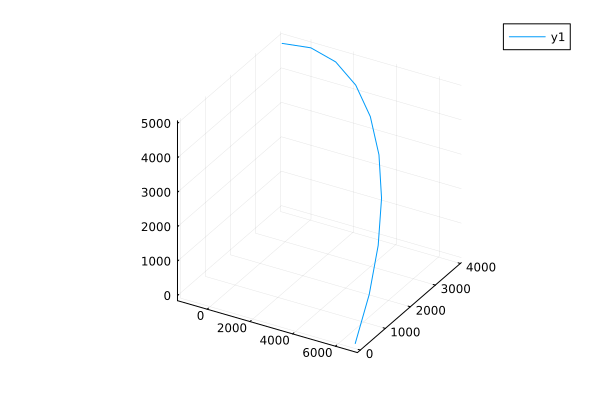

In [15]:
plot(xtraj[1,:], xtraj[2,:], xtraj[3,:])

In [16]:
#not completely periodic. off in the y and the z be 10's of km

In [17]:
#integrate with rk4 to see how much better it is compared to symplectic euler
x_traj_rk4 = zeros(6, N)

6×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [18]:
x_traj_rk4[:,1] = x_initial 

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [19]:
for i = 1:N-1

    x_traj_rk4[:,i+1] = rk4_integrator(x_traj_rk4[:,i])

end

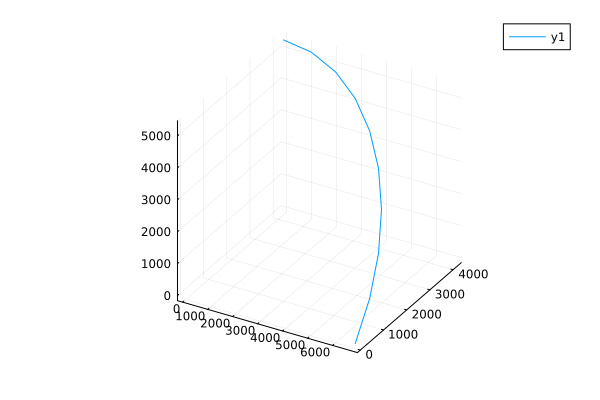

In [20]:
plot(x_traj_rk4[1,:], x_traj_rk4[2,:], x_traj_rk4[3,:])

In [21]:
#difference between the symplectic euler and rk4 final positions after 5 rev sim
x_traj_rk4[:,end] - xtraj[:,end] 

6-element Vector{Float64}:
 1149.2439639523432
  359.27439248844485
  451.66981394741015
    0.6089374882695635
    0.34423103422956547
    0.43275772066163265

In [22]:
function two_body_dynamics_form!(du, u, p, t)

    du[1:6] = two_body_dynamics(u[1:6])

end

two_body_dynamics_form! (generic function with 1 method)

In [23]:
#rk78 integrator using DifferentialEquations.jl
function two_body_dynamics_integrate(x_0, period)

    tspan = (0.0, period)
    prob = ODEProblem(two_body_dynamics_form!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)


    return sol 
end

two_body_dynamics_integrate (generic function with 1 method)

In [24]:
function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [25]:
period  

1392.3601493207534

In [26]:
#use rk78 to integrate the initial condition to 5 revs and check the trajectory 
final_state_sol = two_body_dynamics_integrate(x_initial, period)

retcode: Success
Interpolation: 3rd order Hermite
t: 44-element Vector{Float64}:
    0.0
    0.015420761572399714
    0.03973162174632696
    0.07504175761147455
    0.12639569705908932
    0.19896876272950367
    0.3224337491964102
    0.49042461239594526
    0.7195320692507651
    1.0463564696437295
    ⋮
  844.7871822850349
  918.6175353579018
  993.2425147246615
 1068.564885692482
 1144.529208782582
 1221.1158864199535
 1298.3365148745381
 1376.2402162342285
 1392.3601493207534
u: 44-element Vector{Vector{Float64}}:
 [6791.0, 0.0, 0.0, 0.0, 4.768462116644166, 5.994778481489491]
 [6790.999998972334, 0.07353331736408096, 0.09244404963773876, -0.00013328342280136, 4.768462115922566, 5.994778480582315]
 [6790.999993177981, 0.1894587330667543, 0.2381822709998041, -0.0003434049941977497, 4.768462111853924, 5.994778475467331]
 [6790.999975664162, 0.357833777909273, 0.44985871320505544, -0.0006485945748592281, 4.768462099556179, 5.9947784600069465]
 [6790.999930959346, 0.6027130910906073, 

In [27]:
all_states = get_state(final_state_sol)

6×44 Matrix{Float64}:
 6791.0      6791.0          6791.0          …   122.698        -0.816046
    0.0         0.0735333       0.189459        4225.41       4226.07
    0.0         0.092444        0.238182        5312.06       5312.9
    0.0        -0.000133283    -0.000343405       -7.66133      -7.66258
    4.76846     4.76846         4.76846            0.0846038    -0.00218227
    5.99478     5.99478         5.99478      …     0.106362     -0.00274349

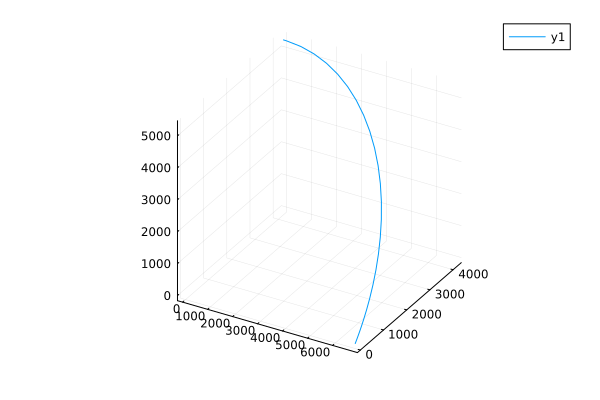

In [28]:
plot(all_states[1,:], all_states[2,:], all_states[3,:]) 

In [29]:
size(all_states)[2]

44

In [30]:
#find a good position and velocity scale 

position_normz = zeros(size(all_states)[2])

velocity_normz = zeros(size(all_states)[2])

for i=1:size(all_states)[2]

    position_normz[i] = norm(all_states[1:3, i])

    velocity_normz[i] = norm(all_states[4:6, i])

end

In [31]:
position_scale = maximum(position_normz) 

#try setting the timescale to scale the period to 1 
#works for the ipopt example 
time_scale = period  

#scale the maximum velocity to 1
#time_scale = position_scale/maximum(velocity_normz)

velocity_scale = position_scale/time_scale

acceleration_scale = position_scale/time_scale^2

μ_scaled = μ/(position_scale^3/time_scale^2)

h_scaled = h/time_scale

0.11111111111111112

In [32]:
time_scale 

1392.3601493207534

In [33]:
position_scale 

6791.0

In [34]:
#difference between ground truth (rk78) and the two integrators (rk4 and semi implicit euler)

diff_semi_euler = all_states[:,end] - xtraj[:,end]

6-element Vector{Float64}:
 1149.2811270849497
  359.35056168518304
  451.76557175157996
    0.6090482931226093
    0.3443418618714525
    0.43289705010296703

In [35]:
diff_rk4 = all_states[:,end] - x_traj_rk4[:,end]

6-element Vector{Float64}:
 0.037163132606463534
 0.07616919673819211
 0.09575780416980706
 0.00011080485304582055
 0.00011082764188704046
 0.00013932944133439795

In [36]:
#going to try the polynomial optimization 

@polyvar q[1:3, 1:N]
@polyvar v[1:3, 1:N]

@polyvar a[1:3, 1:N]

@polyvar r[1:N]

@polyvar u[1:3,1:N-1]

(PolyVar{true}[u₁₋₁ u₁₋₂ … u₁₋₈ u₁₋₉; u₂₋₁ u₂₋₂ … u₂₋₈ u₂₋₉; u₃₋₁ u₃₋₂ … u₃₋₈ u₃₋₉],)

In [37]:

Qq = Matrix(1.0*I, 3,3)

Qv = Matrix(1.0*I, 3,3)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [38]:
x_initial 

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [39]:
#set in kiloNewtons (kN)
umax = 20e-9

#in scaled units 
umax_bound = umax/acceleration_scale

5.709517848377295e-6

In [40]:
#found visually from the unconstrained control case
#this is in the scaled units 

#with the acceleration scale, this corresponds to a maximum of 0.4 N 
#this works 
#u_max_bound = 0.05



#testing 
#doesn't work. maybe not bounding the control space enough 
#u_max_bound = 1/acceleration_scale

In [41]:
#cost function 

f=0

#decreasae the semi major axis
for i=1:N

    f+= 1.0*r[i]

end


#add a cost on controls? (maybe), but it would avoid the bang-bang solution we want 
#introduce a cost or constraint or both

#for i=1:N-1

    #kinda works

    #    f += u[:,i]'*u[:,i]
#end


In [42]:
#initialize equality and inequality constraints 
eq = []
ineq = []

Any[]

In [43]:
x_initial 

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [44]:
x_initial_scaled = [x_initial[1:3]/position_scale; x_initial[4:6]/velocity_scale]

6-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.9776787843853668
 1.2291106849700408

In [45]:
#set the initial condition constraints
append!(eq, [q[1,1] - x_initial_scaled[1]])
append!(eq, [q[2,1] - x_initial_scaled[2]])
append!(eq, [q[3,1] - x_initial_scaled[3]])

append!(eq, [v[1,1] - x_initial_scaled[4]])
append!(eq, [v[2,1] - x_initial_scaled[5]])
append!(eq, [v[3,1] - x_initial_scaled[6]])

6-element Vector{Any}:
 q₁₋₁ - 1.0
 q₂₋₁
 q₃₋₁
 v₁₋₁
 v₂₋₁ - 0.9776787843853668
 v₃₋₁ - 1.2291106849700408

In [46]:
#scaling all the units

In [47]:
#set the dynamics constraint between each timestep 

for i=1:N

    #acceleration constraint
    append!(eq, a[:,i]*r[i]^3 + μ_scaled*q[:,i])

    #slack r constraint 
    append!(eq, [r[i]^2 - q[:,i]'*q[:,i]])

end

In [48]:
#set a constraint on the r's
for i=1:N

    #lower bound on r that we want to reach 
    append!(ineq, [r[i]-0.75])

    #r is always positive (redundant constraint)
    append!(ineq, [r[i]])


end

In [49]:
#two types of control constraints. bound constraint 
# and norm constraint (socp constraint). 
#not sure if it can be handeled without squaring it and making it a polynomial 

#bound constraint 
for i=1:N-1

    #append!(ineq, norm(u_max_bound - u[1,i], 1))
    #maybe it can't handle the norm?
    #append!(ineq, norm(u[1,i] - u_max_bound, 1))


    #bound constraints
    #order 1 polynomial 
    #two inequalities to represent the absolute value 
    #g(x) >= 0
    append!(ineq, [umax_bound - u[1,i]])
    append!(ineq, [u[1,i] + umax_bound])

    append!(ineq, [umax_bound - u[2,i]])
    append!(ineq, [u[2,i] + umax_bound])

    append!(ineq, [umax_bound - u[3,i]])
    append!(ineq, [u[3,i] + umax_bound])


end

In [50]:
#check all the inequality constraints
ineq 

74-element Vector{Any}:
 r₁ - 0.75
 r₁
 r₂ - 0.75
 r₂
 r₃ - 0.75
 r₃
 r₄ - 0.75
 r₄
 r₅ - 0.75
 r₅
 ⋮
 u₂₋₈ + 5.709517848377295e-6
 -u₃₋₈ + 5.709517848377295e-6
 u₃₋₈ + 5.709517848377295e-6
 -u₁₋₉ + 5.709517848377295e-6
 u₁₋₉ + 5.709517848377295e-6
 -u₂₋₉ + 5.709517848377295e-6
 u₂₋₉ + 5.709517848377295e-6
 -u₃₋₉ + 5.709517848377295e-6
 u₃₋₉ + 5.709517848377295e-6

In [51]:
#add a control constraint. square the socp constraint to make it a polynomial

#leaving out for now..
# for i=1:N-1

#     append!(ineq, umax_scaled^2 - u[:,i]'*u[:,i])

# end

In [52]:
#check equality constraints
eq 

46-element Vector{Any}:
 q₁₋₁ - 1.0
 q₂₋₁
 q₃₋₁
 v₁₋₁
 v₂₋₁ - 0.9776787843853668
 v₃₋₁ - 1.2291106849700408
 a₁₋₁r₁³ + 2.4674011002723395q₁₋₁
 a₂₋₁r₁³ + 2.4674011002723395q₂₋₁
 a₃₋₁r₁³ + 2.4674011002723395q₃₋₁
 -q₁₋₁² - q₂₋₁² - q₃₋₁² + r₁²
 ⋮
 -q₁₋₈² - q₂₋₈² - q₃₋₈² + r₈²
 a₁₋₉r₉³ + 2.4674011002723395q₁₋₉
 a₂₋₉r₉³ + 2.4674011002723395q₂₋₉
 a₃₋₉r₉³ + 2.4674011002723395q₃₋₉
 -q₁₋₉² - q₂₋₉² - q₃₋₉² + r₉²
 a₁₋₁₀r₁₀³ + 2.4674011002723395q₁₋₁₀
 a₂₋₁₀r₁₀³ + 2.4674011002723395q₂₋₁₀
 a₃₋₁₀r₁₀³ + 2.4674011002723395q₃₋₁₀
 -q₁₋₁₀² - q₂₋₁₀² - q₃₋₁₀² + r₁₀²

In [53]:
#assuming mass is 1

In [54]:
for i=1:N-1

    #velocity dynamics constraint
    #added a control  
    append!(eq, v[:,i+1] - (v[:,i] + h_scaled*(a[:,i] + u[:,i])))

    #position dynamics constraint 
    append!(eq, q[:,i+1] - (q[:,i] + h_scaled*v[:,i+1]))

end

In [55]:
#add the inequality constraint
pop = append!([f], ineq)

#add the equality constraint
pop = append!(pop, eq)

175-element Vector{Polynomial{true, Float64}}:
 r₁ + r₂ + r₃ + r₄ + r₅ + r₆ + r₇ + r₈ + r₉ + r₁₀
 r₁ - 0.75
 r₁
 r₂ - 0.75
 r₂
 r₃ - 0.75
 r₃
 r₄ - 0.75
 r₄
 r₅ - 0.75
 ⋮
 -q₁₋₈ + q₁₋₉ - 0.11111111111111112v₁₋₉
 -q₂₋₈ + q₂₋₉ - 0.11111111111111112v₂₋₉
 -q₃₋₈ + q₃₋₉ - 0.11111111111111112v₃₋₉
 -v₁₋₉ + v₁₋₁₀ - 0.11111111111111112a₁₋₉ - 0.11111111111111112u₁₋₉
 -v₂₋₉ + v₂₋₁₀ - 0.11111111111111112a₂₋₉ - 0.11111111111111112u₂₋₉
 -v₃₋₉ + v₃₋₁₀ - 0.11111111111111112a₃₋₉ - 0.11111111111111112u₃₋₉
 -q₁₋₉ + q₁₋₁₀ - 0.11111111111111112v₁₋₁₀
 -q₂₋₉ + q₂₋₁₀ - 0.11111111111111112v₂₋₁₀
 -q₃₋₉ + q₃₋₁₀ - 0.11111111111111112v₃₋₁₀

In [56]:
#relaxation order
d = 2

2

In [57]:
#concatenate all the variables together 
var = [vec(q); vec(v); vec(a); r; vec(u)]

127-element Vector{PolyVar{true}}:
 q₁₋₁
 q₂₋₁
 q₃₋₁
 q₁₋₂
 q₂₋₂
 q₃₋₂
 q₁₋₃
 q₂₋₃
 q₃₋₃
 q₁₋₄
 ⋮
 u₁₋₇
 u₂₋₇
 u₃₋₇
 u₁₋₈
 u₂₋₈
 u₃₋₈
 u₁₋₉
 u₂₋₉
 u₃₋₉

In [58]:
#solve 
#TS defines term sparsity 
#without the control bound constraint it takes 18 seconds for 5 revs!
#the local solver is unable to refine the solution for 5 revs because the solution to the sdp is a 
#bad initial guess to the nlp solver. it doesn't satisfy the constraints...

#kinda working with some supoptimality gap for 1/4 rev 
#this uses ipopt to refine the solution
opt, sol, data = cs_tssos_first(pop, var, d, numeq=length(eq), TS="MD", solution=true)


#extract the moment matrix without ipopt solve to check global optimality (with chordal sparsity and term sparsity)
#sol will be empty here...
#opt, sol, data = cs_tssos_first(pop, var, d, numeq=length(eq), TS="MD", solution=false, Mommat=true)

*********************************** TSSOS ***********************************
TSSOS is launching...
-----------------------------------------------------------------------------
The clique sizes of varibles:
[9, 8, 7, 6, 5, 4, 3, 2]
[1, 22, 21, 4, 3, 52, 3, 3]
-----------------------------------------------------------------------------
Obtained the variable cliques in 0.048352012 seconds. The maximal size of cliques is 9.
Starting to compute the block structure...
Obtained the block structure in 0.250395447 seconds.
The maximal size of blocks is 10.
Assembling the SDP...
There are 2987 affine constraints.
SDP assembling time: 1.871912965 seconds.
Solving the SDP...
Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2987            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0       

(7.500505221320507, [1.0, 0.0, 0.0, 0.9695381874881314, 0.1086309055204776, 0.136567783345024, 0.9081835906424821, 0.21380039829776518, 0.2687839920075939, 0.8166063399802296  …  -5.695490893032164e-6, 4.780890097023308e-6, -5.6678308566182005e-6, -5.678365842250424e-6, 5.2492514762868465e-6, -5.6132983338282744e-6, -5.6348643831746964e-6, 4.804206681136775e-6, -5.397528930476569e-6, -5.461914345253002e-6], TSSOS.mcpop_data(127, 0, 174, 100, Vector{Vector{UInt16}}[[[0x005b], [0x005c], [0x005d], [0x005e], [0x005f], [0x0060], [0x0061], [0x0062], [0x0063], [0x0064]], [[0x005b], []], [[0x005b]], [[0x005c], []], [[0x005c]], [[0x005d], []], [[0x005d]], [[0x005e], []], [[0x005e]], [[0x005f], []]  …  [[0x0036], [0x0039], [0x0054], [0x007c]], [[0x0016], [0x0019], [0x0037]], [[0x0017], [0x001a], [0x0038]], [[0x0018], [0x001b], [0x0039]], [[0x0037], [0x003a], [0x0055], [0x007d]], [[0x0038], [0x003b], [0x0056], [0x007e]], [[0x0039], [0x003c], [0x0057], [0x007f]], [[0x0019], [0x001c], [0x003a]], [[

In [59]:
#the data.moment extracts the moment matrix and it is a vector of 
#matrices that construct the block diagonals of the moment matrix

In [60]:
all_condition_numbers = zeros(size(data.moment)[1]) 

for i=1:size(data.moment)[1]

    all_condition_numbers[i] = cond(data.moment[i])
    
end

In [61]:
findmax(all_condition_numbers) 

(8.471981000238104e11, 103)

In [62]:
#construct moment matrix

#initialize row size and column size 
row_size = 0
column_size = 0

#get the amount of rows 
for i=1:size(data.moment)[1]

    row_size += size(data.moment[i])[1]
    column_size += size(data.moment[i])[2]

end

#get the amount of columns

In [63]:
#construct the moment matrix 
moment_matrix = zeros(row_size, column_size)

#initialize row and column index 
row_index = 1
column_index = 1

for i=1:size(data.moment)[1]

    moment_matrix[row_index:row_index + size(data.moment[i])[1]-1, column_index:column_index + size(data.moment[i])[2]-1] = data.moment[i]

    row_index += size(data.moment[i])[1]
    column_index += size(data.moment[i])[2]


end

In [64]:
rank(moment_matrix) 

703

In [65]:
#inifinite condition number without the ipopt refinement...
cond(moment_matrix)

8.577219315031958e11

In [66]:
#need to reshape this 
x_traj_pop = sol[1: size(vec(q))[1]]

x_traj_pop = reshape(x_traj_pop, 3, N)

3×10 Matrix{Float64}:
 1.0  0.969538  0.908184  0.816606  …  0.206787  0.0190779  -0.16936
 0.0  0.108631  0.2138    0.311855     0.563138  0.57728     0.569384
 0.0  0.136568  0.268784  0.392056     0.707962  0.725741    0.715815

In [67]:
norm(x_traj_pop[:,1]) 

1.0

In [68]:
v_traj_pop = sol[size(vec(q))[1]+1: size(vec(q))[1] + size(vec(v))[1]]

v_traj_pop = reshape(v_traj_pop, 3, N)

3×10 Matrix{Float64}:
 0.0       -0.274156  -0.552191  …  -1.61844   -1.68938   -1.69594
 0.977679   0.977678   0.946525      0.320488   0.127275  -0.0710595
 1.22911    1.22911    1.18995       0.40291    0.160007  -0.0893332

In [69]:
a_traj_pop = sol[size(vec(q))[1]+size(vec(v))[1]+1: size(vec(q))[1] + size(vec(v))[1] + size(vec(a))[1]]

a_traj_pop = reshape(a_traj_pop, 3, N)

3×10 Matrix{Float64}:
 -2.4674  -2.50231   -2.44803   …  -0.638537  -0.0589907   0.519184
  0.0     -0.280369  -0.576304     -1.73891   -1.78501    -1.74549
  0.0     -0.352472  -0.724513     -2.18611   -2.24406    -2.19438

In [70]:
r_traj_pop = sol[size(vec(q))[1]+size(vec(v))[1]+size(vec(a))[1]+1: size(vec(q))[1]+size(vec(v))[1]+size(vec(a))[1] + size(vec(r))[1]]

10-element Vector{Float64}:
 1.0
 0.9851171149055036
 0.970954622515436
 0.958022422586681
 0.9468249496425465
 0.9378312681207738
 0.9314413081279604
 0.9279524815128496
 0.9275319159787117
 0.9301999572040265

In [71]:
u_traj_pop = sol[size(vec(q))[1]+size(vec(v))[1]+size(vec(a))[1]+size(vec(r))[1]+1: end]

u_traj_pop = reshape(u_traj_pop, 3, N-1)

3×9 Matrix{Float64}:
 -5.71319e-6  -5.70972e-6  -5.70293e-6  …   5.24925e-6   4.80421e-6
 -5.71231e-6  -5.711e-6    -5.7089e-6      -5.6133e-6   -5.39753e-6
 -5.71378e-6  -5.71274e-6  -5.71107e-6     -5.63486e-6  -5.46191e-6

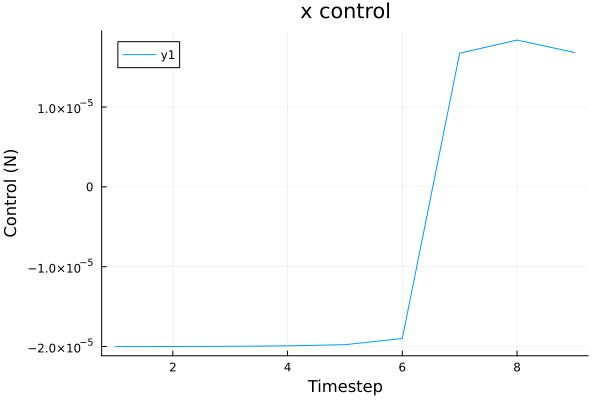

In [72]:
plot(u_traj_pop[1,:]*acceleration_scale*1e3, title="x control", ylabel="Control (N)", xlabel="Timestep") 

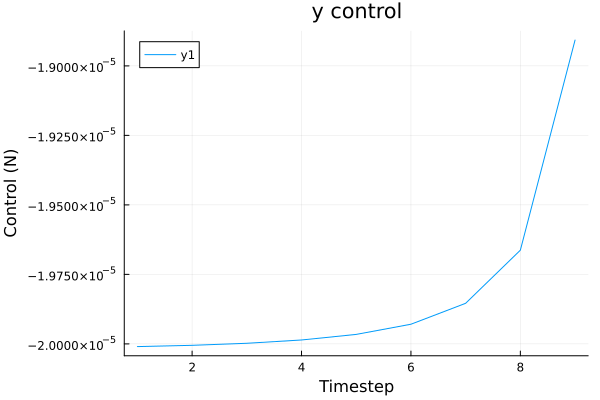

In [73]:
plot(u_traj_pop[2,:]*acceleration_scale*1e3, title="y control", ylabel="Control (N)", xlabel="Timestep") 

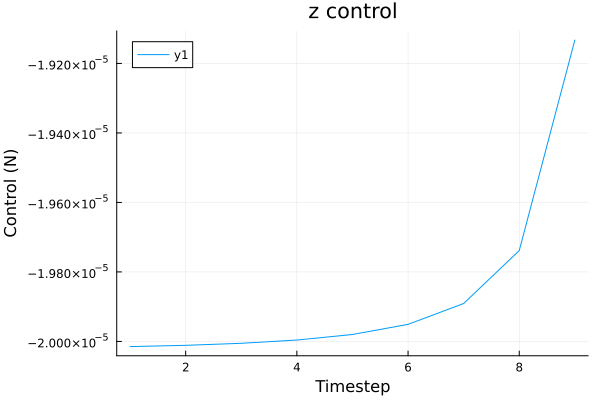

In [74]:
plot(u_traj_pop[3,:]*acceleration_scale*1e3, title="z control", ylabel="Control (N)", xlabel="Timestep") 

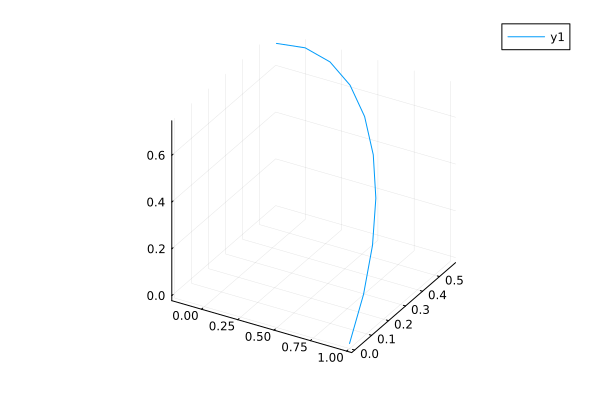

In [75]:
plot(x_traj_pop[1,:], x_traj_pop[2,:], x_traj_pop[3,:])

#plot!(xtraj[1,:]/position_scale, xtraj[2,:]/position_scale, xtraj[3,:]/position_scale)

In [76]:
difference = x_traj_pop - xtraj[1:3, :]/position_scale 

3×10 Matrix{Float64}:
 0.0  -7.05332e-8  -2.17492e-7  -4.5638e-7   …  -3.20452e-6  -3.62674e-6
 0.0  -7.05223e-8  -2.10221e-7  -4.20174e-7     -3.36022e-6  -4.64713e-6
 0.0  -7.05405e-8  -2.10514e-7  -4.225e-7       -3.70157e-6  -5.22974e-6

In [77]:
#r constraint not being satisfied...

In [78]:
#check the initial condition. constraint not satisfied...
x_traj_pop[:,1] - x_initial_scaled[1:3]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [79]:
v_traj_pop[:,1] - x_initial_scaled[4:6]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [80]:
#check the constraints: 

position_constraint = zeros(3,N-1)

velocity_constraint = zeros(3,N-1)

acceleration_constraint = zeros(3,N)

r_constraint = zeros(N)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [81]:
x_traj_pop 

3×10 Matrix{Float64}:
 1.0  0.969538  0.908184  0.816606  …  0.206787  0.0190779  -0.16936
 0.0  0.108631  0.2138    0.311855     0.563138  0.57728     0.569384
 0.0  0.136568  0.268784  0.392056     0.707962  0.725741    0.715815

In [82]:
for i=1:N-1

    
    velocity_constraint[:,i] = v_traj_pop[:,i+1] - (v_traj_pop[:,i] + h_scaled*(a_traj_pop[:,i] + u_traj_pop[:,i]))

    position_constraint[:,i] = x_traj_pop[:,i+1] - (x_traj_pop[:,i] + h_scaled*v_traj_pop[:,i+1])
    

end

In [83]:
for i=1:N

    acceleration_constraint[:,i] = a_traj_pop[:,i]*r_traj_pop[i]^3 + μ_scaled*x_traj_pop[:,i]

    r_constraint[i] = r_traj_pop[i]^2 - x_traj_pop[:,i]'*x_traj_pop[:,i]

end

In [84]:
position_constraint  

3×9 Matrix{Float64}:
 0.0  0.0          0.0  0.0  -1.11022e-16  0.0  0.0   1.38778e-17  0.0
 0.0  0.0          0.0  0.0   0.0          0.0  0.0   0.0          0.0
 0.0  5.55112e-17  0.0  0.0   0.0          0.0  0.0  -1.11022e-16  0.0

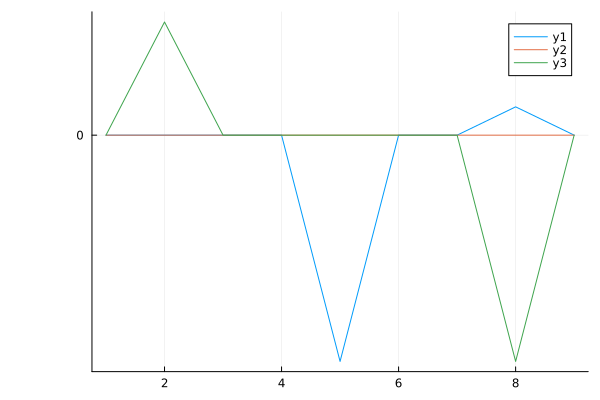

┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [85]:
plot(position_constraint')

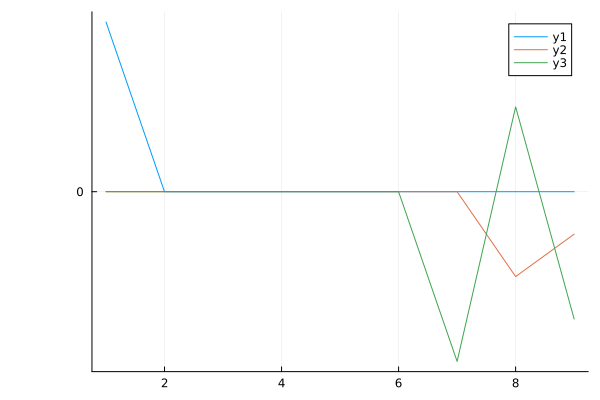

┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [86]:
plot(velocity_constraint')

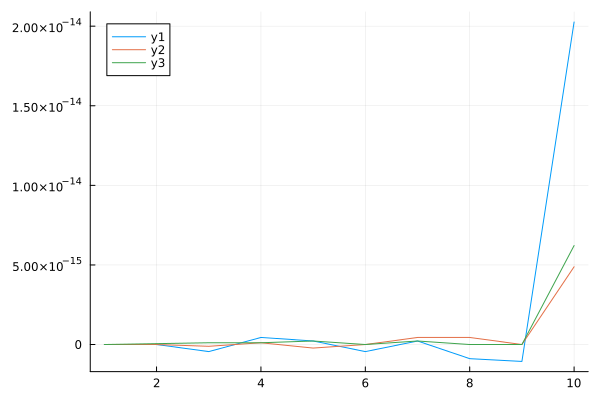

In [87]:
plot(acceleration_constraint')

In [ ]:
#satisfies the constraints for 0.25 revs...